In [106]:
import numpy as np

import pandas as pd
df = pd.read_csv("./data.csv", dtype={"spec":str})
df

,spec,variant,comb,real_tests,real_downs,real_solutions,limit_tests,limit_downs,limit_solutions,approx_tests,approx_downs,approx_solutions
0,12108445569812518508,12108445569812518508,11727443247756548222,10,6,2,10,6,2,10,6,2
1,12108445569812518508,12108445569812518508,10852793995559917114,36,16,4,36,20,8,36,20,8
2,12108445569812518508,12108445569812518508,16503017991964024325,20,10,2,20,12,4,20,12,4
3,12108445569812518508,12108445569812518508,4580224252362903624,20,12,4,20,12,4,20,12,4
4,12108445569812518508,12108445569812518508,15669527594539255932,18,8,2,18,10,4,18,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...
594718,4741471328757961492,9137733444192864134,16891545057722610330,204,132,65,282,189,96,163,91,38
594719,4741471328757961492,135103469565557258,16891545057722610330,204,132,65,282,189,96,163,91,38
594720,4741471328757961492,11674173521891241503,16891545057722610330,204,132,65,282,189,96,163,91,38
594721,4741471328757961492,9251935584853194889,16891545057722610330,204,132,65,282,189,96,163,91,38


In [107]:
maximums = df.groupby(["variant"]).max().loc[:, "real_tests":].add_prefix("max_")
maximums

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions
variant,,,,,,,,,
1852545206220150,204,132,65,282,189,96,163,91,38
3963044581815506,884,348,128,884,476,256,884,476,256
10896267892651436,980,372,128,980,500,256,980,500,256
11366195937547253,165,82,28,354,261,144,153,85,35
11852731444955654,564,268,128,948,492,256,948,492,256
...,...,...,...,...,...,...,...,...,...
18442614969933109485,144,78,31,282,189,96,118,58,19
18443908929398183330,52,28,16,52,28,16,52,28,16
18444699359579702856,980,372,128,980,500,256,980,500,256


In [108]:
squished = pd.read_csv("./squished.csv").set_index("variant").add_suffix("_squished")
squished

,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
variant,,,,,,,
12108445569812518508,12108445569812518508,44,28,16,44,24,12
13295520056715543416,12108445569812518508,48,28,16,40,22,12
849832514006898133,12108445569812518508,44,28,16,44,24,12
2242271814187683694,12108445569812518508,48,28,16,40,22,12
14543158900860426855,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...
9137733444192864134,4741471328757961492,282,189,96,163,91,38
135103469565557258,4741471328757961492,282,189,96,163,91,38
11674173521891241503,4741471328757961492,282,189,96,163,91,38


In [109]:
out = maximums.join(squished, on="variant").sort_values("max_real_tests")
out

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
variant,,,,,,,,,,,,,,,,
455433835029453866,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
9592099295490535412,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
757967249813600158,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
11534756378514934989,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
4281292345261825678,26,10,4,26,14,8,26,14,8,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378249427281752224,1364,468,128,1876,980,512,1876,980,512,16019103864220737052,1876,980,512,1876,980,512
3147635377442717592,1364,468,128,1876,980,512,1876,980,512,517725150128787027,1876,980,512,1876,980,512
6511487006695433315,1364,468,128,1876,980,512,1876,980,512,517725150128787027,1876,980,512,1876,980,512


In [110]:
s = pd.Series(list(range(len(out))))
out = out.set_index(s)
out

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
0,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
1,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
2,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
3,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
4,26,10,4,26,14,8,26,14,8,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465,1364,468,128,1876,980,512,1876,980,512,16019103864220737052,1876,980,512,1876,980,512
18466,1364,468,128,1876,980,512,1876,980,512,517725150128787027,1876,980,512,1876,980,512
18467,1364,468,128,1876,980,512,1876,980,512,517725150128787027,1876,980,512,1876,980,512
18468,1364,468,128,1876,980,512,1876,980,512,4333112432045336723,1876,980,512,1876,980,512


<AxesSubplot:>

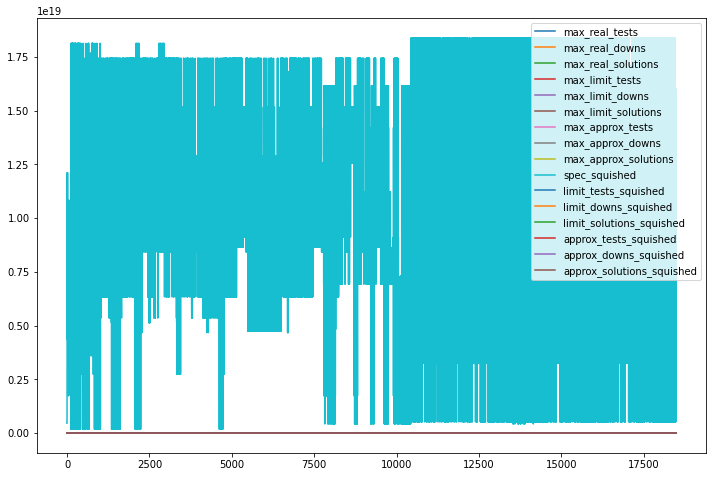

In [111]:
out.plot(figsize=(12,8))

<AxesSubplot:>

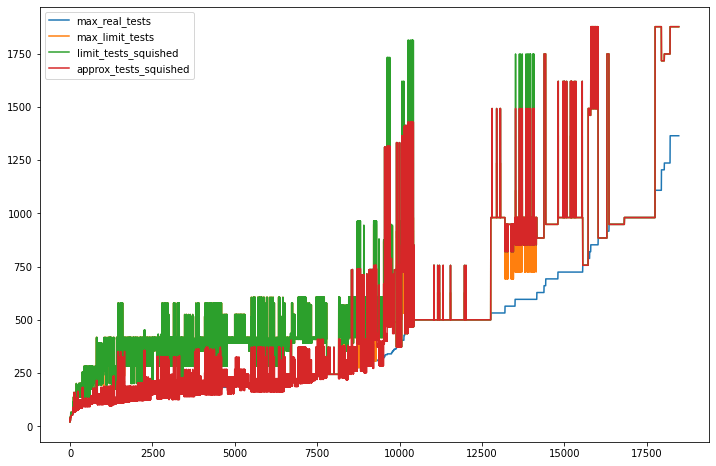

In [112]:
out.loc[:, ["max_real_tests", "max_limit_tests", "limit_tests_squished", "approx_tests_squished"]]\
    .plot(figsize=(12,8))

<AxesSubplot:>

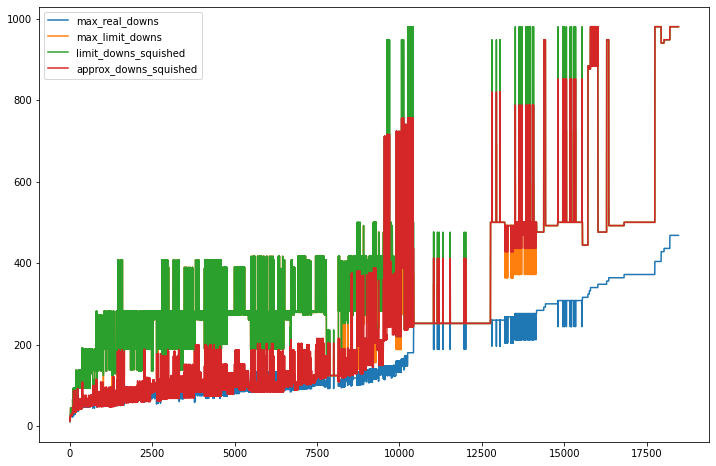

In [113]:
out.loc[:, ["max_real_downs", "max_limit_downs", "limit_downs_squished", "approx_downs_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

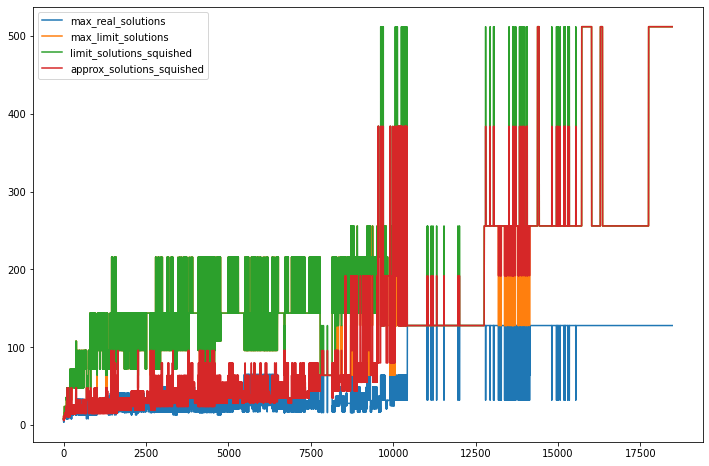

In [114]:
out.loc[:, ["max_real_solutions", "max_limit_solutions", "limit_solutions_squished", "approx_solutions_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

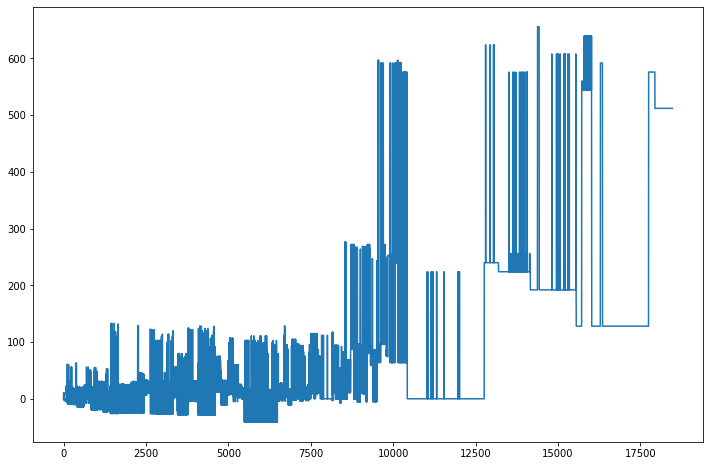

In [115]:
(out["approx_downs_squished"] - out["max_real_downs"]).plot(figsize=(12,8))

In [116]:
opti = pd.read_csv("./optimized.csv", dtype={"spec":str}).loc[:, ["spec", "variant", "real_tests", "real_downs"]].groupby("spec").max()
opti

,variant,real_tests,real_downs
spec,,,
10815156060926821767,10815156060926821767,54,34
11204728505163233027,11204728505163233027,165,75
11534756378514934989,11534756378514934989,27,15
12108445569812518508,12108445569812518508,28,12
12559025754536737892,12559025754536737892,192,91
12885258375908215470,12885258375908215470,204,116
12953346285257496490,12953346285257496490,105,50
14206637112525783207,14206637112525783207,244,124
14656770549137025409,14656770549137025409,948,364


In [117]:
d = df.loc[:, ["spec", "variant", "real_tests", "real_downs"]].groupby("variant").max()
d

,spec,real_tests,real_downs
variant,,,
1852545206220150,4741471328757961492,204,132
3963044581815506,5194669012592534116,884,348
10896267892651436,14656770549137025409,980,372
11366195937547253,12559025754536737892,165,82
11852731444955654,4611717659576826314,564,268
...,...,...,...
18442614969933109485,8636249804829048022,144,78
18443908929398183330,7033118010806448046,52,28
18444699359579702856,3239550213894202592,980,372


In [118]:
d = d.groupby("spec").agg(["min", "max", "mean"]).sort_values(("real_tests", "min"))
d

real_tests                   real_downs                 
                            min   max        mean        min  max        mean
spec                                                                         
455433835029453866           20    20   20.000000         12   12   12.000000
11534756378514934989         24    39   30.000000         14   19   16.000000
12108445569812518508         26    36   30.000000         10   16   12.666667
4368343078470841610          27    27   27.000000         17   17   17.000000
9162266772960708378          45    75   60.500000         24   34   29.166667
5305729146562270160          45    84   59.000000         27   40   31.666667
7033118010806448046          52    52   52.000000         28   28   28.000000
1742929675504911335          52    52   52.000000         28   28   28.000000
7890057643787317850          52    84   62.666667         28   36   30.666667
10815156060926821767         54    54   54.000000         34   34   34.000000
3586104345019983748          58   116   74.166667         22   44   29.500000
2729689496016371213          66   183  112.200000         34   73   49.400000
18119705410931593880         75   159  105.900000         45   73   55.300000
12953346285257496490         75   144  105.000000         40   63   50.000000
177559304024233784           75   183  114.600000         43   79   56.200000
5130092311373643354          84   165  110.700000         52   79   60.900000
11204728505163233027        105   354  186.500000         55  138   82.166667
9714975236029888930         105   105  105.000000         67   67   67.000000
8428064223339944453         105   336  195.500000         51  128   81.166667
17431164762292391779        105   372  205.000000         59  148   92.333333
7477339265531854697         116   212  164.000000         60   84   72.000000
16808279640612739988        116   212  142.666667         60   84   66.666667
17651791471431691119        116   116  116.000000         60   60   60.000000
4670017203538888187         116   212  142.666667         60   84   66.666667
5348792166403156151         122   276  171.600000         46  100   65.200000
6334867478381564086         123   249  176.300000         66  108   83.766667
12559025754536737892        123   273  179.050000         68  118   86.683333
8636249804829048022         123   360  196.250000         71  150   95.416667
15161950521306176458        132   318  209.100000         71  133   96.700000
9111785187471779450         132   372  209.700000         80  160  105.900000
9775501639762534162         138   300  194.650000         86  140  104.883333
12885258375908215470        159   318  207.400000        101  154  117.133333
4741471328757961492         204   204  204.000000        132  132  132.000000
4825067230882273624         244   468  349.600000        124  180  150.400000
14206637112525783207        244   468  298.400000        124  180  137.600000
16157161065153572827        244   468  308.000000        124  180  140.000000
1735359963175934935         244   596  356.000000        124  212  152.000000
6930517132855907012         244   244  244.000000        124  124  124.000000
7294746705470859436         244   596  356.000000        124  212  152.000000
421499015704685401          244   596  397.600000        124  212  162.400000
6921529449609026617         250   724  383.933333         94  244  140.600000
18387057289156117220        500  1364  738.933333        252  468  311.733333
3239550213894202592         500   980  626.933333        252  372  283.733333
17077727626614043257        500   980  604.533333        252  372  278.133333
7677842944498222074         500   980  706.933333        252  372  303.733333
5194669012592534116         500  1364  818.933333        252  468  331.733333
16019103864220737052        500  1364  830.666667        252  468  334.666667
14656770549137025409        500   980  724.000000        252  372  308.000000
517725150128787027          500  1364  842.

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='spec'>

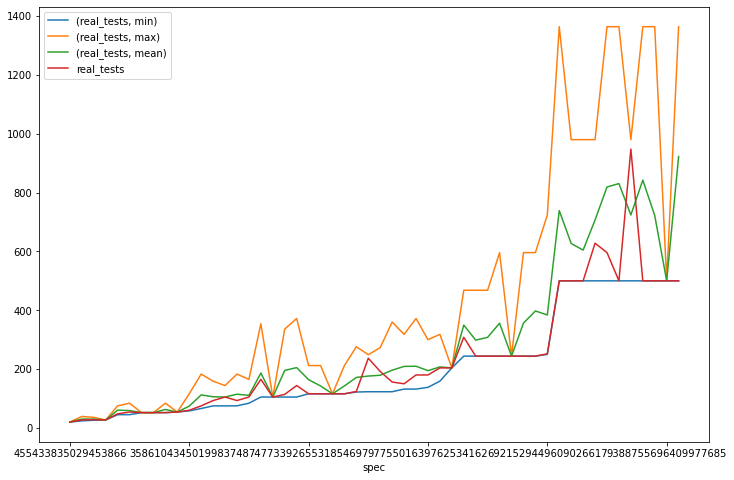

In [119]:
d.loc[:, ["real_tests"]].join(opti.loc[:, ["real_tests"]], on="spec", rsuffix="opti").plot(figsize=(12,8))

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='spec'>

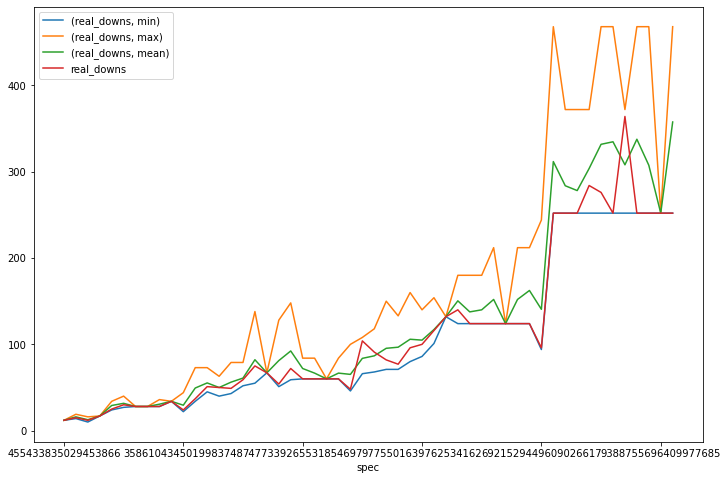

In [120]:
d.loc[:, ["real_downs"]].join(opti.loc[:, ["real_downs"]], on="spec", rsuffix="opti").plot(figsize=(12,8))
